# Node classification with Node2Vec using Stellargraph components

This example demonstrates how to perform node classification with Node2Vec using the Stellargraph components. This uses a keras implementation of Node2Vec available in stellargraph instead of the reference implementation provided by ``gensim``.

<a name="refs"></a>
**References**

[1] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](https://snap.stanford.edu/node2vec/))

[2] Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

[3] word2vec Parameter Learning Explained. X. Rong. arXiv preprint arXiv:1411.2738. 2014 Nov 11. ([link](https://arxiv.org/pdf/1411.2738.pdf))

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/node2vec/stellargraph-keras-node2vec-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/node2vec/stellargraph-keras-node2vec-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

## Introduction
Following word2vec [2,3], for each (``target``,``context``) node pair (vi,vj) collected from random walks,  we learn representation for vi by using the target node vi to predict the existence of context node vj, with the following three-layer neural network.

![](word2vec-illustration.png)

Node vi's representation in the hidden layer is obtained by multiplying vi's one-hot representation in the input layer with the input-hidden weight matrix Win, which is equivalent to look up the ith row of input-to-hidden matrix Win. The existence probability of each node conditioned on node vi is outputted in the output layer, which is obtained by multiplying vi's hidden layer representation with the hidden-to-out weight matrix Wout followed by a softmax activation. To capture the ``target-context`` relations between vi and vj, we need to maximize the probability P(vj|vi). However, computing P(vj|vi) is time consuming, which involves the matrix multiplication between vi's hidden representation and the hidden-to-out matrix Wout. 

To speed up the computing, we adopt the negative sampling strategy [2,3]. For each (``target``, ``context``) node pair, we sample a negative node vk, which is not vi's context. To obtain the output, instead of multiplying vi's hidden representation with the hidden-to-out weight matrix Wout followed by a softmax activation, we only calculate the dot product between vi's hidden layer representation and the jth column as well as the kth column of the hidden-to-output weight matrix Wout followed by a sigmoid activation. According to [3], the original objective to maximize P(vj|vi) can be approximated by minimizing the cross entropy between vj and vk's outputs and their ground-truth labels (+1 for vj and -1 for vk).

Following [2,3], we note the rows of the input-to-hidden matrix Win as ``input_embeddings`` and the columns of the hidden-to-out matrix Wout as ``output_embeddings``. To build the Node2Vec model, we need look up ``input_embeddings`` for target nodes and ``output_embeddings`` for context node and calculate their inner product together with a sigmoid activation.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd
from tensorflow import keras

from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

### Dataset


For clarity, we use only the largest connected component, ignoring isolated nodes and subgraphs; having these in the data does not prevent the algorithm from running and producing valid results.

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, subjects = dataset.load(largest_connected_component_only=True)

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]


### The Node2Vec algorithm

The Node2Vec algorithm introduced in [[1]](#refs) is a 2-step representation learning algorithm. The two steps are:

1. Use random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm [[2]](#refs) is used for calculating the embedding vectors.

In this implementation, we train the Node2Vec algorithm in the following two steps:

1. Generate a set of (`target`, `context`) node pairs through starting the biased random walk with a fixed length at per node. The starting nodes are taken as the target nodes and the following nodes in biased random walks are taken as context nodes. For each (`target`, `context`) node pair, we generate 1 negative node pair.

2. Train the Node2Vec algorithm through minimizing cross-entropy loss for `target-context` pair prediction, with the predictive value obtained by performing the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node, followed by a sigmoid activation.

Specify the optional parameter values: the number of walks to take per node, the length of each walk. Here, to guarantee the running efficiency, we respectively set `walk_number` and `walk_length` to 100 and 5. Larger values can be set to them to achieve better performance.

In [6]:
walk_number = 100
walk_length = 5

Create the biased random walker to perform context node sampling, with the specified parameters.

In [7]:
walker = BiasedRandomWalk(
    G,
    n=walk_number,
    length=walk_length,
    p=0.5,  # defines probability, 1/p, of returning to source node
    q=2.0,  # defines probability, 1/q, for moving to a node away from the source node
)

Create the UnsupervisedSampler instance with the biased random walker.

In [8]:
unsupervised_samples = UnsupervisedSampler(G, nodes=list(G.nodes()), walker=walker)

Set the batch size and the number of epochs.

In [9]:
batch_size = 50
epochs = 2

Define an attri2vec training generator, which generates a batch of (index of target node, index of context node, label of node pair) pairs per iteration.

In [10]:
generator = Node2VecLinkGenerator(G, batch_size)

Build the Node2Vec model, with the dimension of learned node representations set to 128.

In [11]:
emb_size = 128
node2vec = Node2Vec(emb_size, generator=generator)

In [12]:
x_inp, x_out = node2vec.in_out_tensors()

Use the link_classification function to generate the prediction, with the 'dot' edge embedding generation method and the 'sigmoid' activation, which actually performs the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node followed by a sigmoid activation.

In [13]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
)(x_out)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


Stack the Node2Vec encoder and prediction layer into a Keras model. Our generator will produce batches of positive and negative context pairs as inputs to the model. Minimizing the binary crossentropy between the outputs and the provided ground truth is much like a regular binary classification task.

In [14]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

Train the model.

In [15]:
history = model.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Train for 39760 steps
Epoch 1/2
39760/39760 [==============================] - 178s 4ms/step - loss: 0.2968 - binary_accuracy: 0.8531
Epoch 2/2
39760/39760 [==============================] - 193s 5ms/step - loss: 0.1091 - binary_accuracy: 0.9643


## Visualise Node Embeddings

Build the node based model for predicting node representations from node ids and the learned parameters. Below a Keras model is constructed, with x_inp[0] as input and x_out[0] as output. Note that this model's weights are the same as those of the corresponding node encoder in the previously trained node pair classifier.

In [16]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

Get the node embeddings from node ids.

In [17]:
node_gen = Node2VecNodeGenerator(G, batch_size).flow(G.nodes())
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

50/50 [==============================] - 0s 1ms/step


Transform the embeddings to 2d space for visualisation.

In [18]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

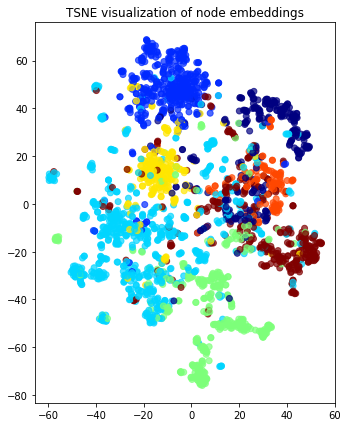

In [19]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(subjects))}
node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

### Node Classification
In this task, we will use the `Node2Vec` node embeddings to train a classifier to predict the subject of a paper in Cora.

In [20]:
# X will hold the 128-dimensional input features
X = node_embeddings
# y holds the corresponding target values
y = np.array(subjects)

### Data Splitting

We split the data into train and test sets. 

We use 10% of the data for training and the remaining 90% for testing as a hold-out test set.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (248, 128)
 y_train = (248,)
 X_test = (2237, 128)
 y_test = (2237,)


### Classifier Training

We train a Logistic Regression classifier on the training data. 

In [22]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=300, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring='accuracy',
                     solver='lbfgs', tol=0.0001, verbose=False)

Predict the hold-out test set.

In [23]:
y_pred = clf.predict(X_test)

Calculate the accuracy of the classifier on the test set.

In [24]:
accuracy_score(y_test, y_pred)

0.7116674117121145

<table><tr><td>Run the master version of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/node2vec/stellargraph-keras-node2vec-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/node2vec/stellargraph-keras-node2vec-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>